# **START SESSION**

In [ ]:
!pip install pyspark

In [1]:
import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer

import matplotlib.pyplot as plt
import pandas as pd
import tempfile
import numpy as np
import seaborn as sns 
%matplotlib inline

In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Proyek PBD Cluster E-Commerce") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
spark

# **CONVERT AND LOAD DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
data = spark.read.load("/content/drive/MyDrive/PROYEK PBD/dataset/data.csv",
                     format="csv", inferSchema="true", header="true")

Konversi format data yang sebelumnya berupa format CSV, menjadi Hadoop Format file dalam format **Parquet**.

In [ ]:
data.write.format("parquet").mode("overwrite").save("/content/drive/MyDrive/PROYEK PBD/dataset/data_parq")

In [5]:
data_parq = spark.read.load("/content/drive/MyDrive/PROYEK PBD/dataset/data_parq",
                     format="parquet", inferSchema="true", header="true")

# **EXPLORATORY DATA**

In [6]:
data_parq.show(10)
data_parq.printSchema()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

In [7]:
#check deskripsi dataset
data_parq.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|         541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|           null|4.611113626082972|15287.690570239585|       null|
| stddev|13428.417280800133| 16799.73762842775|                null|218.08115785023486|           null| 96.7598530611797| 1713.600303321594|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -8

# **DATA CLEANING AND DATA MANIPULATION**

**CLEANING DATA FROM NULL VALUES**

In [8]:
from pyspark.sql.functions import count
#check and remove the null values
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

In [9]:
my_count(data_parq)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   541909|   541909|     540455|  541909|     541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Melalui proses penghitungan, ditemukan sejumlah baris data pada setiap kolom tidak sama, pada kolom **CustomerID** terdapat nilai null. Maka record data yang memiliki nilai null akan dihapus dari frame data dengan menggunakan fungsi .dropna()

In [10]:
ecom_data = data_parq.dropna(how='any')
my_count(ecom_data)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   406829|   406829|     406829|  406829|     406829|   406829|    406829| 406829|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



**DATA MANIPULATION**

**1. Manipulasi Perhitungan Total Price**

Dilakukan perhitungan untuk kolom baru yakni Total Price dangan menggunakan perkalian antara Quantity dengan UnitPrice (Quantity * Unit Price)

In [11]:
from pyspark.sql.functions import round

ecom_data = ecom_data.withColumn('TotalPrice', round( ecom_data.Quantity * ecom_data.UnitPrice, 2 ) )
ecom_data.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|      15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|      22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|
+---------+---------+--------------------+--------+--------------+---------+----------+-

**2. Manipulasi Format Tanggal**

Jika dilihat di kolom InvoiceData masih dalam format MM/dd/yy HH:mm. Dikarenakan Spark sangat sensitive terhadap format tanggal, maka diperlukan membuat sebuah kolom baru dengan nama kolom **NewInvoiceDate** dengan menggunakan value yang terdapat pada kolom InvoiceDate

In [21]:
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

timeFmt = "MM/dd/yy HH:mm"

ecom_data = ecom_data.withColumn('NewInvoiceDate'
                 , to_utc_timestamp(unix_timestamp(col('InvoiceDate'),timeFmt).cast('timestamp')
                 , 'UTC'))

In [22]:
ecom_data.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+-------------------+--------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|     NewInvoiceDate|Duration|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+-------------------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|      15.3|2010-12-01 08:26:00|    null|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|2010-12-01 08:26:00|    null|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|      22.0|2010-12-01 08:26:00|    null|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|2010-12-01 08:26:00|    null|

**3. Manipulasi Perhitungan Time Difference (Duration)**

In [24]:
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date

date_max = ecom_data.select(max('NewInvoiceDate')).toPandas()
current = to_utc_timestamp( unix_timestamp(lit(str(date_max.iloc[0][0])), \
                              'yy-MM-dd HH:mm').cast('timestamp'), 'UTC' )

#Calculatre Duration
ecom_data = ecom_data.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))


In [25]:
ecom_data.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+-------------------+--------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|     NewInvoiceDate|Duration|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----------+-------------------+--------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|      15.3|2010-12-01 08:26:00|     373|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|2010-12-01 08:26:00|     373|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|      22.0|2010-12-01 08:26:00|     373|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|     20.34|2010-12-01 08:26:00|     373|

# **RFM ANALYSIS METHODOLOGY**

RFM (Recency, Frequency, and Monetary) merupakan sebuah metode yang digunakan untuk menganalisis value dari customer. RFM biasanya digunakan pada basisdata marketing dan direct marketing dan telah mendapatkan perhatian khusus dalam industri jasa retail dan profesional. Berikut merupakan rincian lebih lanjut mengenai RFM:

*   Recency Value, merepresentasikan seberapa baru pelanggan membeli sesuatu? misalnya: durasi sejak pembelian terakhir
*   Frequency Value, merepresentasikan seberapa sering pelanggan membeli? misalnya: Jumlah total pembelian
*   Monetary Value, merepresentasikan seberapa banyak yang dibelanjakan pelanggan? misalnya: Total uang yang dihabiskan pelanggan


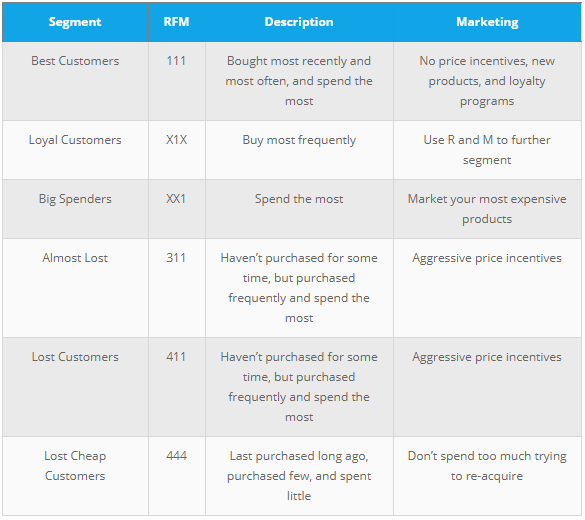

# **RFM SEGMENTATION**

**BUILD THE REGENCY, FREQUENCY AND MONETARY**

In [27]:
recency = ecom_data.groupBy('CustomerID').agg(min('Duration').alias('Recency'))

frequency = ecom_data.groupBy('CustomerID', 'InvoiceNo').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))

monetary = ecom_data.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))

rfm = recency.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')

In [29]:
rfm.show(10)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     10|        1|   336.4|
|     17389|      0|       43|31300.08|
|     12940|     46|        4|  876.29|
|     13623|     30|        7|  672.44|
|     14450|    180|        3|  483.25|
|     15727|     16|        7| 5178.96|
|     15790|     10|        1|  220.85|
|     13285|     23|        4| 2709.12|
|     14570|    280|        2|  218.06|
|     16574|     71|        1|  451.44|
+----------+-------+---------+--------+
only showing top 10 rows



**SEGMENTASI RFM**

**A. Menentukan Cutting Point**

*Cutting Point* merupakan sebuah metode yang digunakan untuk memilah penggunaan suatu kriteria untuk dijadikan sebagai pertimbangan dalam pengambilan sebuah keputusan terhadap suatu masalah. Metode *Cutting Point* juga digunakan untuk memastikan seberapa penting derajat sebuah kriteria.

**B. Fungsi Mendefenisikan User dengan menggunakan persen Kuartil sebagai Cutting Points**

Kuartil digunakan untuk membagi populasi kedalam berbagai kelompok. Misalnya untuk menemukan 25% total pengeluaran uang teratas (Monetary) pada populasi data online retail yang digunakan pada proyek adalah sebesar 293.362 

In [34]:
def describe_pd(df_in, columns, style):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param style: the display style
    :return : the numerical describe info. of the input dataframe
    :author: MIng Chen and Wenqiang Feng
    :email: von198@gmail.com
    '''
    if style == 1:
        percentiles = [25, 50, 75]
    else:
        percentiles = np.array(range(0, 110, 10))
    
    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]
    
    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [36]:
cols = ['Recency','Frequency','Monetary']
describe_pd(rfm,cols,1)

,summary,Recency,Frequency,Monetary
0,count,4372,4372,4372
1,mean,91.58119853613907,5.07548032936871,1898.4597003659658
2,stddev,100.77213931384833,9.338754163574729,8219.345141139722
3,min,0,1,-4287.63
4,max,373,248,279489.02
5,25%,16,1,293.362
6,50%,50,3,648.075
7,75%,143,5,1611.72


**C. Mendefenisikan score segmen RFM berdasarkan quartil**

***Kuartil 1 (Q1) = 25%***

*   Untuk score R (Recency) <= 16
*   Untuk score F (Frequency) <= 1
*   Untuk score M (Monetary) <= -4287.63

***Kuartil 2 (Q2) = 50%***

*   Untuk score R (Recency) <= 50
*   Untuk score F (Frequency) <= 3
*   Untuk score M (Monetary) <= 648.075

***Kuartil 3 (Q3) = 70%***

*   Untuk score R (Recency) <= 143
*   Untuk score F (Frequency) <= 5
*   Untuk score M (Monetary) <= 1611.72

***Kuartil 4 (Q4)***

Score R, F, M yang tepat berada lebih besar dari score untuk Kuartil 3 (70%)

In [37]:
def RScore(x):
    if  x <= 16:
        return 1
    elif x<= 50:
        return 2
    elif x<= 143:
        return 3
    else:
        return 4

def FScore(x):
    if  x <= 1:
        return 4
    elif x <= 3:
        return 3
    elif x <= 5:
        return 2
    else:
        return 1

def MScore(x):
    if  x <= 293:
        return 4
    elif x <= 648:
        return 3
    elif x <= 1611:
        return 2
    else:
        return 1

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())

**D. Implementasi Segmentasi RFM**

In [38]:
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     15619|     10|        1|   336.4|    1|    4|    3|
|     17389|      0|       43|31300.08|    1|    1|    1|
|     12940|     46|        4|  876.29|    2|    2|    2|
|     13623|     30|        7|  672.44|    2|    1|    2|
|     14450|    180|        3|  483.25|    4|    3|    3|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



**E. Menentukan score RFM**

Dengan menggabungkan score dari masing-masing segmen R, F, dan M menggunakan fungsi Concat

In [39]:
from pyspark.sql import functions as F
rfm_seg = rfm_seg.withColumn('RFMScore',
                             F.concat(F.col('r_seg'),F.col('f_seg'), F.col('m_seg')))
rfm_seg.sort(F.col('RFMScore')).show(10)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     16549|     10|       10| 4154.64|    1|    1|    1|     111|
|     13225|      3|        8| 6083.04|    1|    1|    1|     111|
|     15382|     14|        8| 5927.86|    1|    1|    1|     111|
|     17809|     16|       15| 4627.62|    1|    1|    1|     111|
|     14713|      9|       12| 2664.26|    1|    1|    1|     111|
|     18161|     10|        6| 1612.79|    1|    1|    1|     111|
|     17754|      0|        6| 1739.92|    1|    1|    1|     111|
|     12471|      2|       49|18740.92|    1|    1|    1|     111|
|     15727|     16|        7| 5178.96|    1|    1|    1|     111|
|     17389|      0|       43|31300.08|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 10 rows

